In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
#drive.mount('/content/drive')

# Define the path to your dataset in Google Drive
# Assuming the dataset is in a folder named 'Dental' in the root of your Google Drive
fire_path = '/content/drive/MyDrive/Dental_Dataset3/train/cavity/'
no_fire_path = '/content/drive/MyDrive/Dental_Dataset3/train/no_cavity/'

# Load the paths
fire_path_list = os.listdir(fire_path)
fire_path_list = [fire_path + f for f in fire_path_list]

no_fire_path_list = os.listdir(no_fire_path)
no_fire_path_list = [no_fire_path + f for f in no_fire_path_list]

# Create a DataFrame
df = pd.DataFrame({'Path': fire_path_list + no_fire_path_list})
df['Label'] = df['Path'].apply(lambda x: 0 if 'no_cavity' in x else 1)
df['Label_String'] = df['Label'].apply(lambda x: 'no cavity' if x == 0 else 'cavity')

# Shuffle
df = df.sample(frac=1.0).reset_index(drop=True)

# Display the first lines
pd.options.display.max_colwidth = 400
df.head()


,Path,Label,Label_String
0,/content/drive/MyDrive/Dental_Dataset3/train/cavity/images (13).jpg,1,cavity
1,/content/drive/MyDrive/Dental_Dataset3/train/cavity/287.jpg,1,cavity
2,/content/drive/MyDrive/Dental_Dataset3/train/no_cavity/675.jpg,0,no cavity
3,/content/drive/MyDrive/Dental_Dataset3/train/cavity/617 - Copy.jpg,1,cavity
4,/content/drive/MyDrive/Dental_Dataset3/train/cavity/458.jpg,1,cavity


In [ ]:
# Load the paths
fire_path = '/content/drive/MyDrive/Dental_Dataset2/train/cavity/'
fire_path_list = os.listdir(fire_path)
fire_path_list = [fire_path + f for f in fire_path_list]

no_fire_path = '/content/drive/MyDrive/Dental_Dataset2/train/no_cavity/'
no_fire_path_list = os.listdir(no_fire_path)
no_fire_path_list = [no_fire_path + f for f in no_fire_path_list]

In [ ]:
df = pd.DataFrame({'Path': fire_path_list + no_fire_path_list})
df['Label'] = df['Path'].apply(lambda x: 0 if 'non_fire' in x else 1)
df['Label_String'] = df['Label'].apply(lambda x: 'no fire' if x == 0 else 'fire')

# Shuffle
df = df.sample(frac = 1.0).reset_index(drop = True)

# Display the first lines
pd.options.display.max_colwidth = 400
df.head()

,Path,Label,Label_String
0,/content/drive/MyDrive/tethdata/cavity/Tooth_Discoloration_0_7200.jpeg,1,fire
1,/content/drive/MyDrive/tethdata/nocavity/510.jpg,1,fire
2,/content/drive/MyDrive/tethdata/nocavity/281.jpg,1,fire
3,/content/drive/MyDrive/tethdata/nocavity/332.jpg,1,fire
4,/content/drive/MyDrive/tethdata/cavity/Tooth_Discoloration_0_9893.jpeg,1,fire


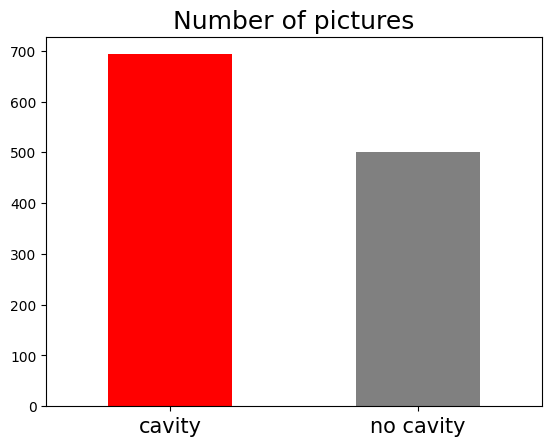

In [39]:
df['Label_String'].value_counts().plot.bar(color = ['red','gray'])
plt.title('Number of pictures', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 15)
plt.show()

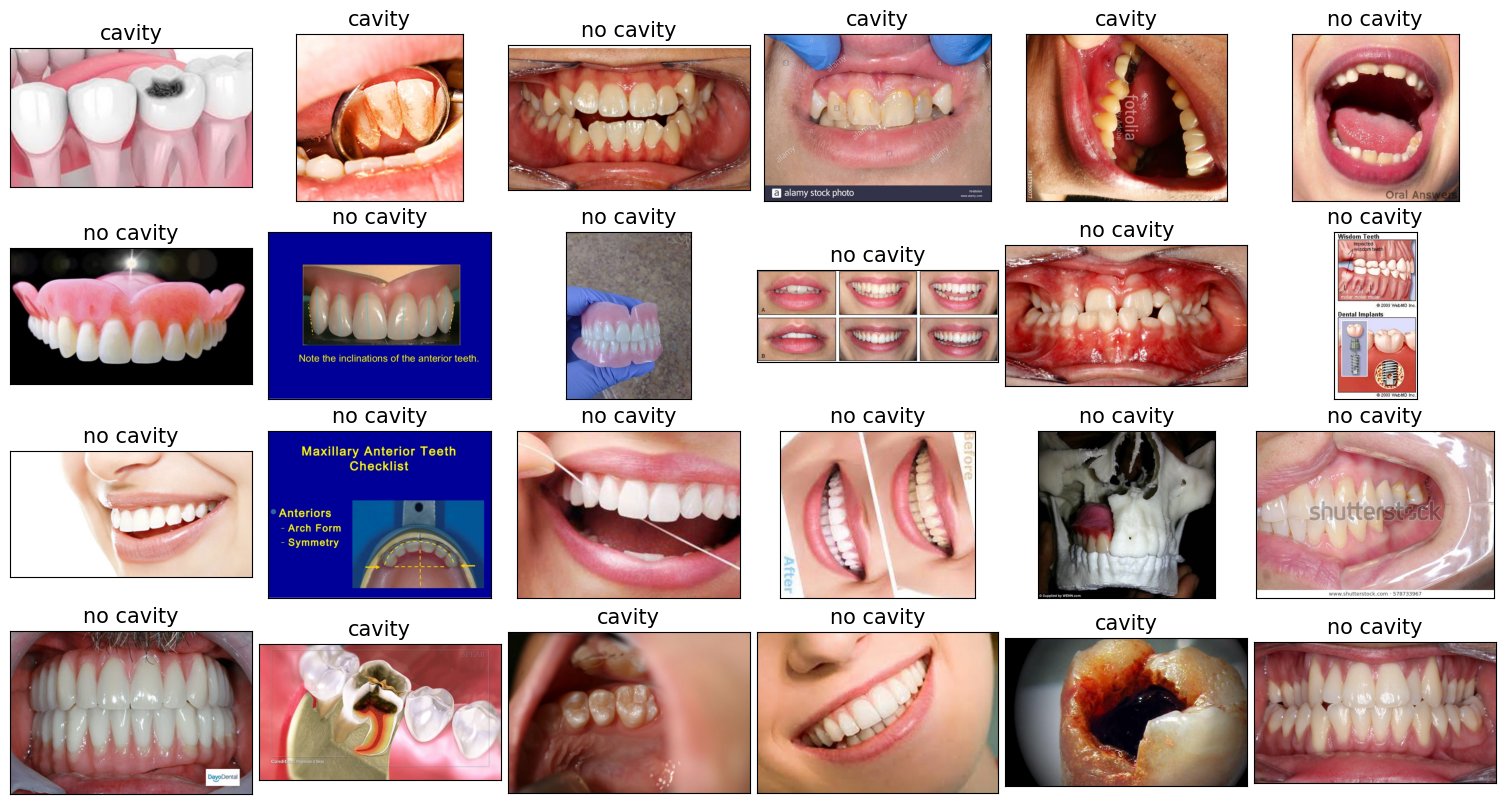

In [40]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = image.load_img(df['Path'].iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = df['Label_String'].iloc[i]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [41]:
df_original = df.copy()

# Split into training, test and validation sets
val_index = int(df_original.shape[0]*0.1)

train_df = df_original.iloc[val_index:]
test_df = df_original.iloc[:val_index]

In [42]:
# Display the shapes of the sets
train_df.shape, test_df.shape

((1075, 3), (119, 3))

In [43]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label_String',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label_String',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Label_String',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 968 validated image filenames belonging to 2 classes.
Found 107 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


In [44]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [45]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 12, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 64,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=11,
            restore_best_weights=True),
            learning_rate_reduction
    ]
)

Epoch 1/30
16/16 [==============================] - 272s 17s/step - loss: 0.4838 - accuracy: 0.7562 - val_loss: 0.3522 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 38s 2s/step - loss: 0.2523 - accuracy: 0.9039 - val_loss: 0.3052 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 37s 2s/step - loss: 0.1468 - accuracy: 0.9483 - val_loss: 0.2898 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 36s 2s/step - loss: 0.0872 - accuracy: 0.9752 - val_loss: 0.3065 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 38s 2s/step - loss: 0.0545 - accuracy: 0.9845 - val_loss: 0.3424 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 39s 2s/step - loss: 0.0293 - accuracy: 0.9948 - val_loss: 0.3643 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 7/30
16/16 [==============================] - 37s 2s/step - loss: 0.0123 -

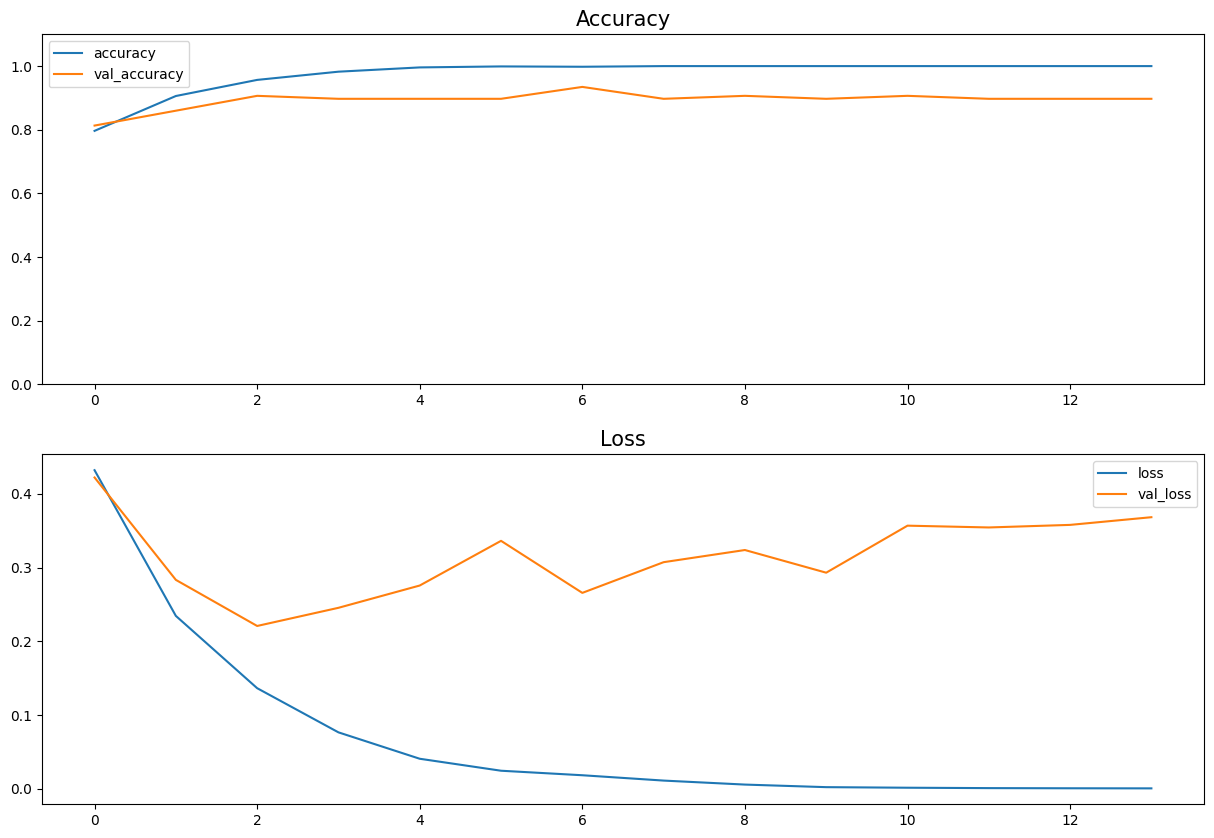

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
import cv2

def preprocessing(path):
    img = image.load_img(path)
    img = tf.keras.preprocessing.image.img_to_array(img)/255
    img = cv2.resize(img, (224,224))
    return img

# Preprocess the test images
path_lst = test_df['Path'].values
X_test = [preprocessing(p) for p in path_lst]
X_test = np.array(X_test)

# Predict the label
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Inverse the 1 and 0 in the label to adapt to the mapping of the neural network
pred = [0 if x == 1 else 1 for x in pred]


y_test = test_df['Label']

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

4/4 [==============================] - 8s 2s/step


## 71.43% accuracy on the test set

In [ ]:
# Get the strings of the prediction
pred = ['cavity' if x == 1 else 'no cavity' for x in pred]
y_test = test_df['Label_String']

In [ ]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

      cavity       0.56      0.93      0.70        42
   no cavity       0.94      0.60      0.73        77

    accuracy                           0.71       119
   macro avg       0.75      0.76      0.71       119
weighted avg       0.80      0.71      0.72       119



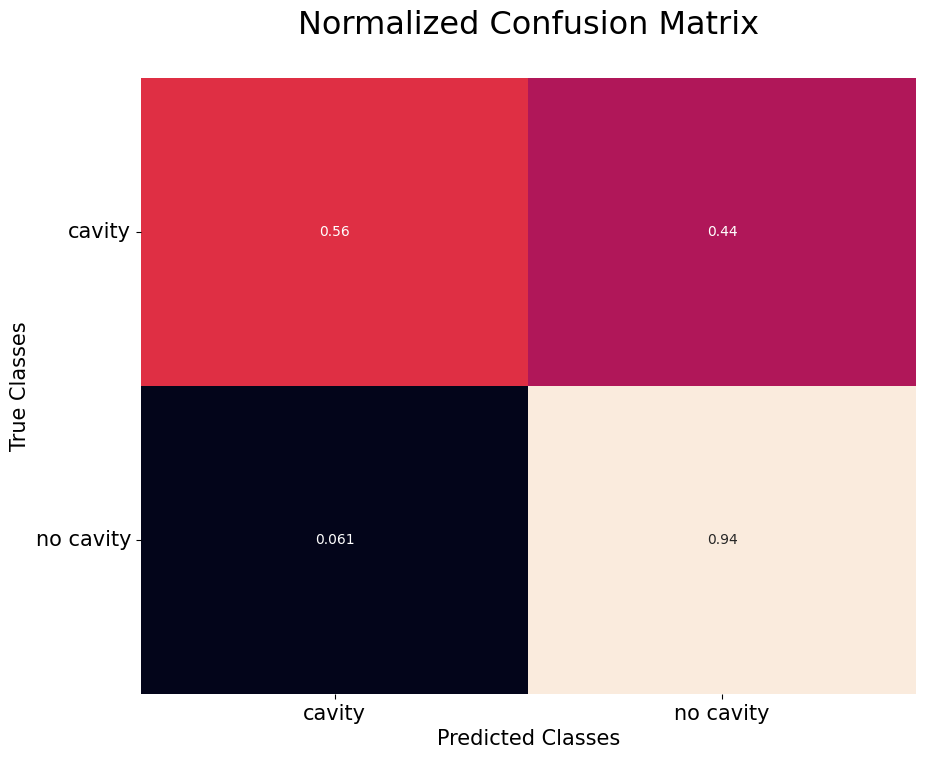

In [ ]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(pred)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
nrows = 20
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows),
                        subplot_kw={'xticks': [], 'yticks': []})

i = 0
for i, nrow in enumerate(range(nrows)):

    img_path = test_df.Path.iloc[i]
    title = f"True: {test_df.Label_String.iloc[i]}\nPredicted: {pred[i]}"

    # Original Picture
    img = image.load_img(img_path)
    axes[nrow,0].imshow(img)
    axes[nrow,0].set_title('ORIGINAL PICTURE\n' + title)

    # Calculate Grad-CAM class activation
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    img = plt.imread(cam_path)
    axes[nrow,1].imshow(img)
    axes[nrow,1].set_title('GRAD-CAM CLASS ACTIVATION\n' + title)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 286ms/step


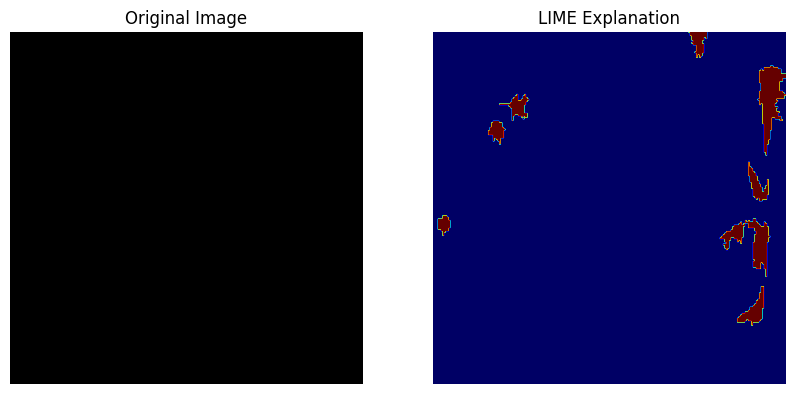

In [ ]:
!pip install lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt

# Function to get image array, similar to your existing function
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to preprocess input and get model prediction
def model_predict(img_array):
    img_array = preprocess_input(img_array)
    preds = model.predict(img_array)
    return preds
    # Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define segmentation algorithm
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# Get image
img_path = '/content/drive/MyDrive/Dental_Dataset2/train/cavity/116.jpg'
img_array = get_img_array(img_path, img_size)
img_array = preprocess_input(img_array)
# Get explanation from LIME
explanation = explainer.explain_instance(
    img_array[0].astype('double'),
    model_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter
)
# Get image and mask for the top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot original image and the LIME explanation
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_array[0] / 255.0)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_array[0] / 255.0)
plt.imshow(mask, cmap='jet', alpha=0.8)
plt.title('LIME Explanation')
plt.axis('off')

plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 300ms/step


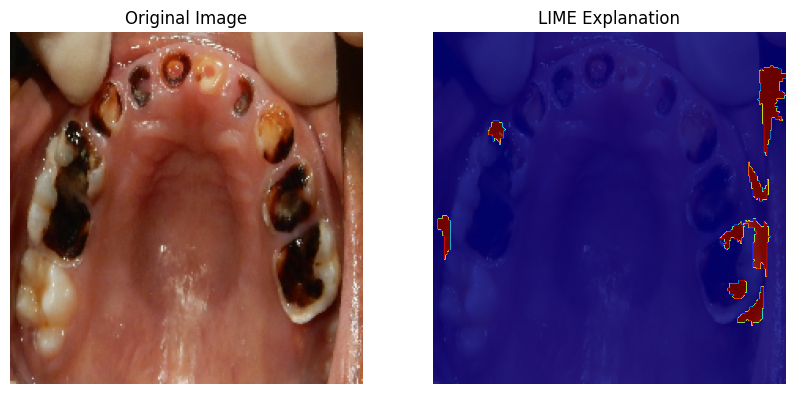

In [ ]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to get image array
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
    # Function to preprocess input and get model prediction
def model_predict(img_array):
    preprocessed_img = preprocess_input(img_array.copy())
    preds = model.predict(preprocessed_img)
    return preds

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define segmentation algorithm
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
# Get image
img_path = '/content/drive/MyDrive/Dental_Dataset2/train/cavity/116.jpg'
img_array = get_img_array(img_path, (224, 224))
preprocessed_img_array = preprocess_input(img_array.copy())  # Preprocess for model prediction
# Get explanation from LIME
explanation = explainer.explain_instance(
    preprocessed_img_array[0].astype('double'),
    model_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter
)
# Get image and mask for the top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)
# Plot original image and the LIME explanation
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_array[0] / 255.0)  # Assuming the original image is in the scale [0, 255]
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_array[0] / 255.0)
plt.imshow(mask, cmap='jet', alpha=0.8)
plt.title('LIME Explanation')
plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 455ms/step


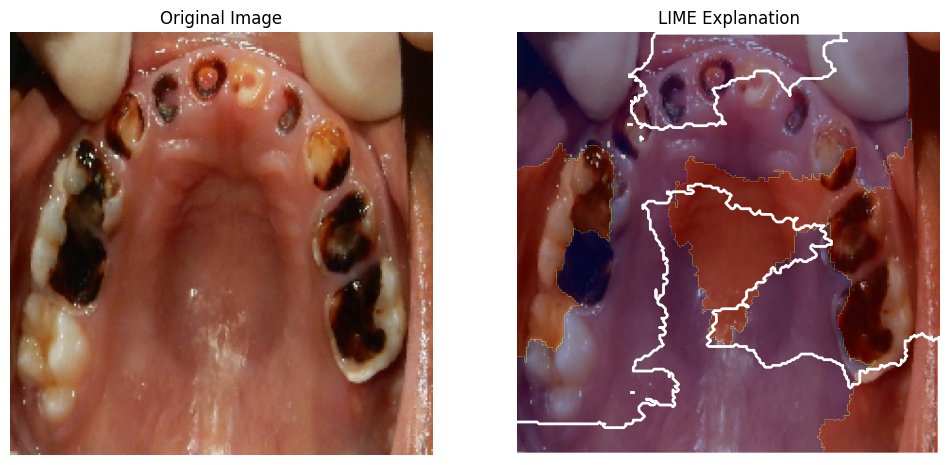

In [ ]:
from lime import lime_image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

# Function to get image array
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to preprocess input and get model prediction
def model_predict(img_array):
    img_array = preprocess_input(img_array.copy())
    return model.predict(img_array)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Image path and size
img_path = '/content/drive/MyDrive/Dental_Dataset2/train/cavity/116.jpg'
img_size = (224, 224)

# Load and preprocess the image
original_img_array = get_img_array(img_path, img_size)
preprocessed_img_array = preprocess_input(original_img_array.copy())

# LIME explanation
explanation = explainer.explain_instance(
    preprocessed_img_array[0].astype('double'),
    model_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Get mask for the top predicted label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Resize the mask to have the same dimensions as the original image
mask = np.expand_dims(mask, axis=-1)  # Add an extra dimension for the channel
mask = np.array(tf.image.resize(mask, img_size))
mask = np.squeeze(mask, axis=-1)  # Remove the extra dimension

# Create contours for the mask
contours, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Display results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_img_array[0] / 255)
plt.title('Original Image')
plt.axis('off')

# Original image with LIME mask and contours
plt.subplot(1, 2, 2)
plt.imshow(original_img_array[0] / 255)
plt.imshow(mask, cmap='jet', alpha=0.3)  # Overlay with transparency
for contour in contours:
    plt.plot(contour[:, :, 1], contour[:, :, 0], linewidth=2, color='white')  # Draw white contour
plt.title('LIME Explanation')
plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 264ms/step


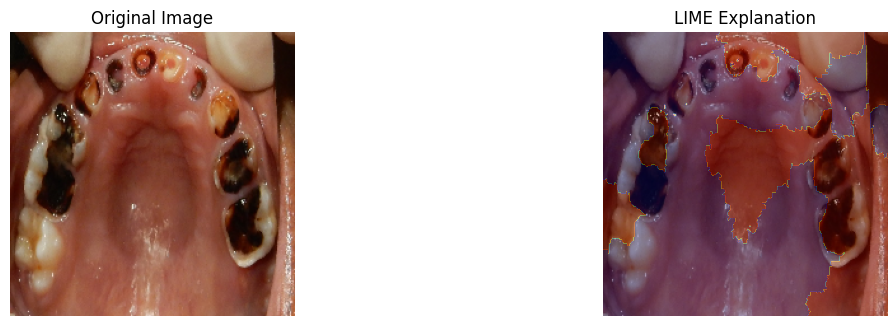

In [ ]:
from lime import lime_image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from glob import glob

# Function to get image array
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to preprocess input and get model prediction
def model_predict(img_array):
    img_array = preprocess_input(img_array.copy())
    return model.predict(img_array)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Image size and directory containing images
img_size = (224, 224)
image_paths = glob('/content/drive/MyDrive/Dental_Dataset2/train/cavity/116.jpg')

# Initialize a large matplotlib figure
plt.figure(figsize=(12, 150))  # width, height in inches

# Loop over all images
for img_index, img_path in enumerate(image_paths):
    original_img_array = get_img_array(img_path, img_size)
    preprocessed_img_array = preprocess_input(original_img_array.copy())

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        preprocessed_img_array[0].astype('double'),
        model_predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Get mask for the top predicted label
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
        # Resize the mask
    mask = np.expand_dims(mask, axis=-1)
    mask = np.array(tf.image.resize(mask, img_size))
    mask = np.squeeze(mask, axis=-1)

    # Plot original image
    plt.subplot(50, 2, img_index * 2 + 1)
    plt.imshow(original_img_array[0] / 255.0)
    plt.title(f'Original Image')
    plt.axis('off')

    # Plot LIME explanation
    plt.subplot(50, 2, img_index * 2 + 2)
    plt.imshow(original_img_array[0] / 255.0)
    plt.imshow(mask, cmap='jet', alpha=0.3)
    plt.title(f'LIME Explanation')
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()
